In [1]:
import os
import numpy as np

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for k in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[k], True)
        print('memory growth:', tf.config.experimental.get_memory_growth(physical_devices[k]))
else:
    print("Not enough GPU hardware devices available")

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Reshape, Dropout, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

Not enough GPU hardware devices available


# データのロード

In [2]:
#!cp /home/kkiku/Castep/calc/dsgdb9nsd/spectrum/npz/NN/noaligned_atomnum/traindata1.npz .
#!cp /home/kkiku/Castep/calc/dsgdb9nsd/spectrum/npz/NN/noaligned_atomnum/testdata.npz .
#!cp /home/kkiku/Castep/calc/dsgdb9nsd/prop_files/all_propertyver1.npz .

In [3]:
#base_dir = "/home/kkiku/Castep/calc/dsgdb9nsd/spectrum/npz/NN/noaligned_atomnum/"
#train_data = np.load(os.path.join(base_dir, 'traindata1.npz'))
#test_data = np.load(os.path.join(base_dir, 'testdata.npz'))

In [4]:
train_data = np.load('traindata1.npz')
test_data = np.load('testdata.npz')

In [5]:
#all_property = np.load("/home/kkiku/Castep/calc/dsgdb9nsd/prop_files/all_propertyver1.npz")
all_property = np.load("all_propertyver1.npz")

In [6]:
all_property["arr_3"]

array(['Rot. const. A', 'Rot. const. B', 'Rot. const. C',
       'Dipole moment mu', 'Isotro. polar. alpha', 'EHOMO', 'ELUMO',
       'EGAP', 'Elect. spatial extent', 'Zero point vib. ene.',
       'Int. ene. 0K', 'Int. ene. 298.15K', 'Enthalpy 298.15K',
       'Free ene. 298.15K', 'Heat capa. 298.15K', 'Mol weight',
       'HMol Weight', 'Atom num', 'HAtomnum', 'C', 'N', 'O', 'F', 'H',
       'single', 'double', 'triple', 'aromatic', 'conjugate', 'sp3ratio',
       'n_ring', 'ring3', 'ring4', 'ring5', 'ring6', 'ring7', 'ring8',
       'ring9'], dtype='<U21')

In [7]:
dir_nums = train_data["arr_1"]
sps = train_data["arr_2"]
props = train_data["arr_3"]

In [8]:
props[0]

array([ 3.92426000e+00,  1.85692000e+00,  1.50511000e+00,  4.22370000e+00,
        6.44300000e+01, -2.66500000e-01,  1.18000000e-02,  2.78300000e-01,
        8.62827700e+02,  1.30700000e-01, -3.83781380e+02, -3.83774360e+02,
       -3.83773420e+02, -3.83812410e+02,  2.71000000e+01,  1.12130000e+02,
        1.04060000e+02,  1.60000000e+01,  8.00000000e+00,  6.00000000e+00,
        0.00000000e+00,  2.00000000e+00,  0.00000000e+00,  8.00000000e+00,
        8.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.00000000e+00,  8.33333333e-01,  2.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.93270534e+02,  6.40080334e-01,
        3.63906887e-01,  9.28965693e-01])

In [9]:
dir_nums_test = test_data["arr_1"]
sps_test = test_data["arr_2"]
props_test = test_data["arr_3"]

## スペクトルの確認

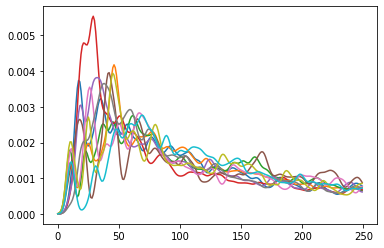

In [10]:
fig, ax = plt.subplots(1)
for i in range(10):
    ax.plot(sps[i])

## 目的変数の確認

今回はpropの後ろから4番目のExcitation energyを使います。

値が大きいので標準化します。

In [11]:
exen = props[:, -4]
exen_avg = np.average(exen)
exen_std = np.std(exen)
exen_standardized = (exen - exen_avg) / exen_std

In [12]:
exen_test = props_test[:, -4]

# NNによる予測

In [13]:
class NN():
    def __init__(self, input_dim=(250,), outputs_dim=1):
        self.input_dim = input_dim
        self.make_model()

    def make_model(self):
        inputs = Input(shape=self.input_dim)
        x = BatchNormalization()(inputs)
        x = Dense(250, activation='relu', kernel_initializer="he_normal")(x)
        x = Dropout(rate=0.3)(x)
        x = Dense(250, activation='relu', kernel_initializer="he_normal")(x)
        x = Dropout(rate=0.3)(x)
        x = Dense(250, activation='relu', kernel_initializer="he_normal")(x)
        x = Dropout(rate=0.3)(x)
        x = Dense(250, activation='relu', kernel_initializer="he_normal")(x)
        x = Dropout(rate=0.3)(x)
        outputs = Dense(1, activation='linear')(x)
        self.model = Model(inputs, outputs) # nn.model
        self.model.compile("adam", "mse") # nn.model.compile

In [14]:
nn = NN()

In [15]:
plot_model(nn.model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [16]:
nn.model.fit(
    sps,
    exen_standardized,
    epochs=10000,
    batch_size=1024,
    shuffle=True,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=500, restore_best_weights=True)]
)

Epoch 1/10000
13/13 [==============================] - 1s 82ms/step - loss: 0.7930 - val_loss: 1.1855
Epoch 2/10000
13/13 [==============================] - 0s 15ms/step - loss: 0.2549 - val_loss: 1.2401
Epoch 3/10000
13/13 [==============================] - 0s 15ms/step - loss: 0.1388 - val_loss: 0.9692
Epoch 4/10000
13/13 [==============================] - 0s 17ms/step - loss: 0.1092 - val_loss: 1.0719
Epoch 5/10000
13/13 [==============================] - 0s 14ms/step - loss: 0.0927 - val_loss: 0.9985
Epoch 6/10000
13/13 [==============================] - 0s 14ms/step - loss: 0.0799 - val_loss: 0.9842
Epoch 7/10000
13/13 [==============================] - 0s 14ms/step - loss: 0.0749 - val_loss: 0.9557
Epoch 8/10000
13/13 [==============================] - 0s 15ms/step - loss: 0.0684 - val_loss: 0.9297
Epoch 9/10000
13/13 [==============================] - 0s 16ms/step - loss: 0.0640 - val_loss: 0.8988
Epoch 10/10000
13/13 [==============================] - 0s 16ms/step - loss: 0.062

In [19]:
nn.model.save_weights("weights_spectra_nn.h5")

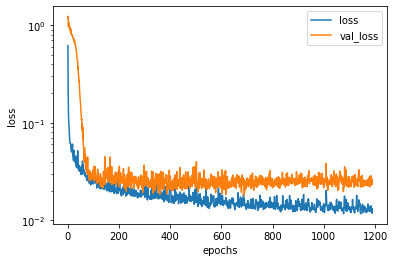

In [20]:
fig, ax = plt.subplots(1)
for label, loss in nn.model.history.history.items():
    ax.plot(nn.model.history.epoch, loss, label=label)
ax.legend()
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.set_yscale("log")

In [21]:
exen_predict_test_standardized = nn.model.predict(sps_test)
exen_predict_test = exen_predict_test_standardized * exen_std + exen_avg

In [22]:
exen_predict_standardized = nn.model.predict(sps)
exen_predict = exen_predict_standardized * exen_std + exen_avg

(289.0, 302.0)

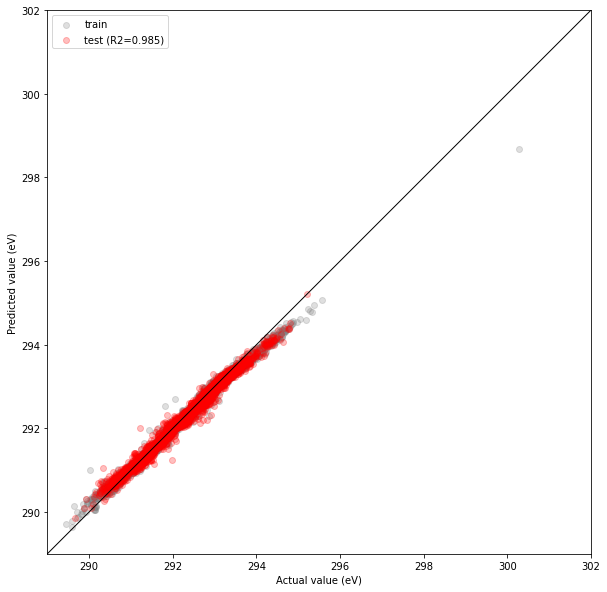

In [23]:
fig, ax = plt.subplots(1, figsize=(10,10))
plot_range = (289, 302)
ax.plot(plot_range, plot_range, c='k', lw=1)
ax.scatter(exen, exen_predict, alpha=0.25, c="gray", label="train")
ax.scatter(exen_test, exen_predict_test, alpha=0.25, c="r", label="test (R2={:.3f})".format(r2_score(exen_test, exen_predict_test)))
ax.set_xlabel("Actual value (eV)")
ax.set_ylabel("Predicted value (eV)")
ax.set_aspect("equal")
ax.legend()
ax.set_xlim(*plot_range)
ax.set_ylim(*plot_range)

# CNNによる予測

In [24]:
class CNN():
    def __init__(self, input_dim=(250,), outputs_dim=1):
        self.input_dim = input_dim
        self.make_model()

    def make_model(self):
        inputs = Input(shape=self.input_dim)
        x = Reshape(self.input_dim + (1,))(inputs)
#        x = BatchNormalization()(x)
        x = Conv1D(32, 13, activation='relu', padding='same', kernel_initializer="he_normal", strides=5)(x)
        x = Conv1D(64, 11, activation='relu', padding='same', kernel_initializer="he_normal", strides=5)(x)
        x = Conv1D(128, 9, activation='relu', padding='same', kernel_initializer="he_normal", strides=5)(x)
        x = Conv1D(256, 2, activation='relu', padding='same', kernel_initializer="he_normal", strides=2)(x)
        x = Reshape((256,))(x)
        outputs = Dense(1, activation='linear')(x)
        self.model = Model(inputs, outputs)
        self.model.compile("adam", "mse")

In [25]:
cnn = CNN()

In [26]:
plot_model(cnn.model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [27]:
cnn.model.fit(
    sps,
    exen_standardized,
    epochs=10000,
    batch_size=2048,
    shuffle=True,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=100, restore_best_weights=True)]
)

Epoch 1/10000
7/7 [==============================] - 1s 67ms/step - loss: 1.0008 - val_loss: 0.9870
Epoch 2/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.9768 - val_loss: 0.9340
Epoch 3/10000
7/7 [==============================] - 0s 52ms/step - loss: 0.9085 - val_loss: 0.8053
Epoch 4/10000
7/7 [==============================] - 0s 53ms/step - loss: 0.7555 - val_loss: 0.5803
Epoch 5/10000
7/7 [==============================] - 0s 54ms/step - loss: 0.5253 - val_loss: 0.3746
Epoch 6/10000
7/7 [==============================] - 0s 52ms/step - loss: 0.3699 - val_loss: 0.3507
Epoch 7/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.3526 - val_loss: 0.3176
Epoch 8/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.3219 - val_loss: 0.2924
Epoch 9/10000
7/7 [==============================] - 0s 53ms/step - loss: 0.3028 - val_loss: 0.2724
Epoch 10/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.2733 - val_loss: 0.2571

KeyboardInterrupt: 

In [28]:
cnn.model.save_weights("weights_spectra_cnn.h5")

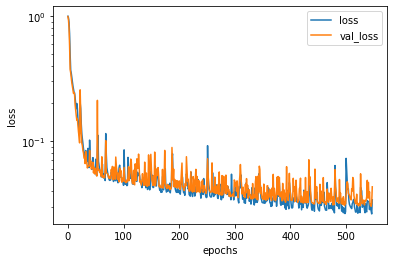

In [29]:
fig, ax = plt.subplots(1)
for label, loss in cnn.model.history.history.items():
    ax.plot(cnn.model.history.epoch, loss, label=label)
ax.legend()
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.set_yscale("log")

In [30]:
exen_predict_test_standardized = cnn.model.predict(sps_test)
exen_predict_test = exen_predict_test_standardized * exen_std + exen_avg

In [31]:
exen_predict_standardized = cnn.model.predict(sps)
exen_predict = exen_predict_standardized * exen_std + exen_avg

(289.0, 302.0)

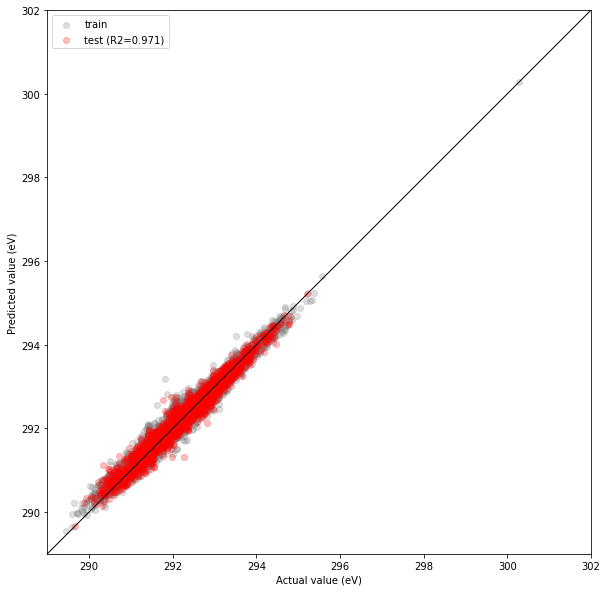

In [32]:
fig, ax = plt.subplots(1, figsize=(10,10))
plot_range = (289, 302)
ax.plot(plot_range, plot_range, c='k', lw=1)
ax.scatter(exen, exen_predict, alpha=0.25, c="gray", label="train")
ax.scatter(exen_test, exen_predict_test, alpha=0.25, c="r", label="test (R2={:.3f})".format(r2_score(exen_test, exen_predict_test)))
ax.set_xlabel("Actual value (eV)")
ax.set_ylabel("Predicted value (eV)")
ax.set_aspect("equal")
ax.legend()
ax.set_xlim(*plot_range)
ax.set_ylim(*plot_range)